# **Klasifikasi Deteksi Emosi pada Teks**

## INSTALL & IMPORT

In [ ]:
!pip install transformers seaborn matplotlib scikit-learn pandas tensorflow

In [ ]:
!pip install --upgrade transformers safetensors huggingface_hub

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tf_keras # Library legacy untuk kompatibilitas Transformers
import re
import string
import os
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional

# Konfigurasi Global
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
BATCH_SIZE = 16

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


## Data Loading, Filtering & Preprocessing

In [ ]:
def clean_text(text):
    """Membersihkan text dari URL, handle, dan tanda baca"""
    text = str(text).lower()
    text = re.sub(r'@\w+', '', text) # Hapus @user
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Hapus URL
    text = text.translate(str.maketrans('', '', string.punctuation)) # Hapus tanda baca
    text = re.sub(r'\s+', ' ', text).strip() # Hapus spasi ganda
    return text

# Load Data
if os.path.exists('tweet_emotions.csv'):
    df = pd.read_csv('tweet_emotions.csv')
else:
    # Dummy data jika file belum ada
    print("Warning: File csv tidak ditemukan. Menggunakan dummy data.")
    df = pd.DataFrame({
        'content': ['I am happy'] * 50 + ['I am sad'] * 50 + ['I worry'] * 50 + ['neutral day'] * 50,
        'sentiment': ['happiness'] * 50 + ['sadness'] * 50 + ['worry'] * 50 + ['neutral'] * 50
    })

# Filter Label
target_labels = ['neutral', 'worry', 'happiness', 'sadness']
df = df[df['sentiment'].isin(target_labels)].reset_index(drop=True)

# Bersihkan Teks
df['content'] = df['content'].apply(clean_text)

# Encoding Label
label_map = {label: idx for idx, label in enumerate(target_labels)}
df['label'] = df['sentiment'].map(label_map)

# Split Data
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['content'].values,
    df['label'].values,
    test_size=0.2,
    random_state=SEED,
    stratify=df['label'].values
)

# Hitung Class Weights (Untuk mengatasi ketidakseimbangan data)
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights_vals))
print(f"Class Weights: {class_weights}")

Class Weights: {0: np.float64(0.7950795947901592), 1: np.float64(0.8118811881188119), 2: np.float64(1.3184545236381089), 3: np.float64(1.329622458857696)}


## Exploratory Data Analysis (EDA)

/tmp/ipython-input-547681054.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=dataframe, order=target_labels, palette='viridis')


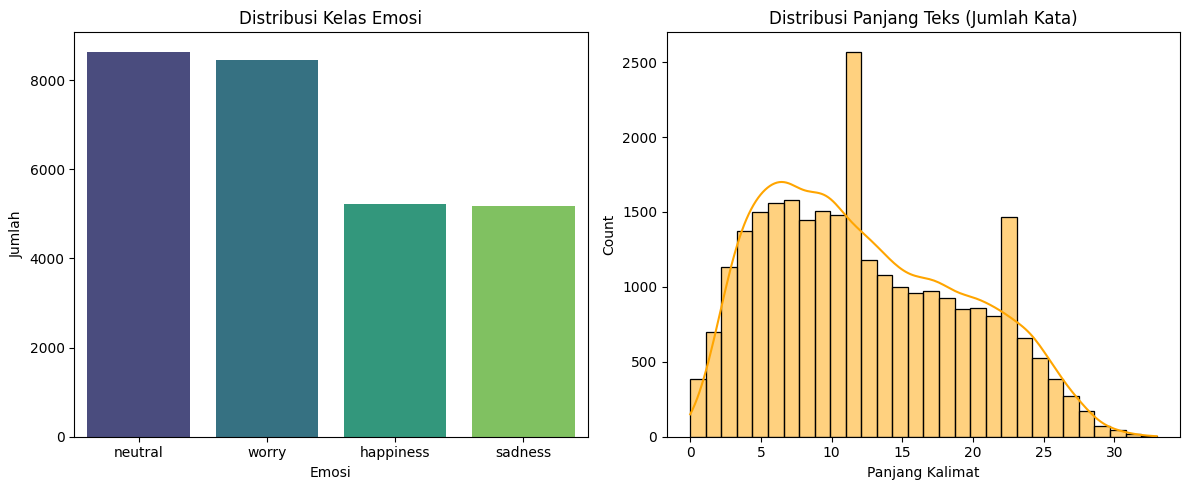

In [ ]:
def plot_eda(dataframe):
    plt.figure(figsize=(12, 5))

    # Plot Distribusi Kelas
    plt.subplot(1, 2, 1)
    sns.countplot(x='sentiment', data=dataframe, order=target_labels, palette='viridis')
    plt.title('Distribusi Kelas Emosi')
    plt.xlabel('Emosi')
    plt.ylabel('Jumlah')

    # Plot Panjang Teks
    dataframe['text_length'] = dataframe['content'].apply(lambda x: len(str(x).split()))
    plt.subplot(1, 2, 2)
    sns.histplot(dataframe['text_length'], bins=30, kde=True, color='orange')
    plt.title('Distribusi Panjang Teks (Jumlah Kata)')
    plt.xlabel('Panjang Kalimat')

    plt.tight_layout()
    plt.show()

plot_eda(df)

## Persiapan Evaluasi (Helper Functions)

In [ ]:
def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy
    ax[0].plot(epochs, acc, label='Train Acc')
    ax[0].plot(epochs, val_acc, label='Val Acc')
    ax[0].set_title(f'{model_name} - Accuracy')
    ax[0].legend()

    # Loss
    ax[1].plot(epochs, loss, label='Train Loss')
    ax[1].plot(epochs, val_loss, label='Val Loss')
    ax[1].set_title(f'{model_name} - Loss')
    ax[1].legend()
    plt.show()

def evaluate_model(model, X_test, y_test, history, model_name, is_transformer=False):
    plot_history(history, model_name)

    # Predict
    if is_transformer:
        y_pred_probs = model.predict(X_test).logits
    else:
        y_pred_probs = model.predict(X_test)

    y_pred = np.argmax(y_pred_probs, axis=1)

    print(f"\n=== Classification Report: {model_name} ===")
    print(classification_report(y_test, y_pred, target_names=target_labels))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_labels, yticklabels=target_labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

def get_transformer_data(tokenizer, texts, labels):
    encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=128, return_tensors='tf')
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels))
    return dataset

## MODEL 1: Neural Network Base (LSTM)


--- Membangun Model Hybrid CNN-LSTM (Versi Stabil) ---
Menggunakan Manual Weights: {0: 1.0, 1: 1.0, 2: 1.5, 3: 1.5}


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 60, 40)         │       400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 58, 32)         │         3,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 58, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 29, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,748 (1.61 MB)

 Trainable params: 421,684 (1.61 MB)

 Non-trainable params: 64 (256.00 B)

Mulai Training...
Epoch 1/25
683/687 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2876 - loss: 1.7868

687/687 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.2878 - loss: 1.7866 - val_accuracy: 0.3712 - val_loss: 1.4640
Epoch 2/25
686/687 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3463 - loss: 1.7004

687/687 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3464 - loss: 1.7003 - val_accuracy: 0.4089 - val_loss: 1.3601
Epoch 3/25
684/687 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4161 - loss: 1.5627

687/687 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.4162 - loss: 1.5624 - val_accuracy: 0.4187 - val_loss: 1.2828
Epoch 4/25
685/687 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4899 - loss: 1.4030

687/687 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.4899 - loss: 1.4028 - val_accuracy: 0.4207 - val_loss: 1.2668
Epoch 5/25
687/687 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.5337 - loss: 1.3048 - val_accuracy: 0.4266 - val_loss: 1.3003
Epoch 6/25
687/687 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.5726 - loss: 1.2077 - val_accuracy: 0.3745 - val_loss: 1.4145
Epoch 7/25
687/687 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6029 - loss: 1.1191 - val_accuracy: 0.4318 - val_loss: 1.4572
Epoch 8/25
687/687 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6248 - loss: 1.0640 - val_accuracy: 0.4288 - val_loss: 1.5621


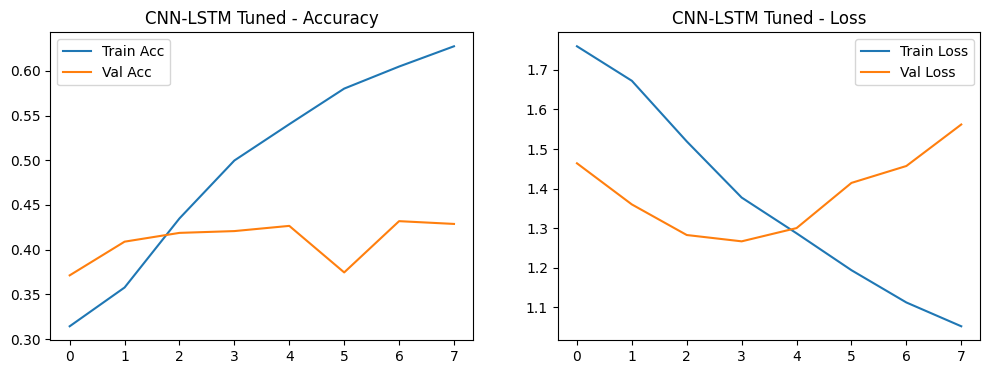

172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

=== Classification Report: CNN-LSTM Tuned ===
              precision    recall  f1-score   support

     neutral       0.53      0.48      0.50      1728
       worry       0.35      0.21      0.26      1692
   happiness       0.51      0.49      0.50      1042
     sadness       0.33      0.60      0.42      1033

    accuracy                           0.42      5495
   macro avg       0.43      0.44      0.42      5495
weighted avg       0.43      0.42      0.41      5495



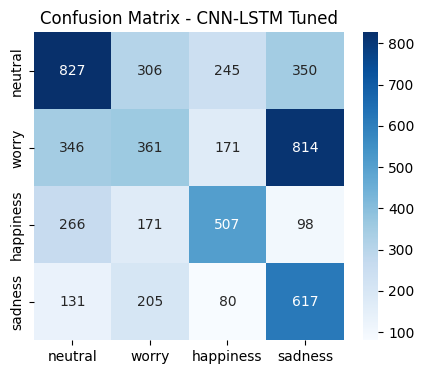

In [ ]:
print("\n--- Membangun Model Hybrid CNN-LSTM (Versi Stabil) ---")

# 1. Setup Data
vocab_size = 10000
max_length = 60
oov_tok = "<OOV>"
embedding_dim = 40

tokenizer_lstm = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_lstm.fit_on_texts(X_train_raw)

# Simpan Tokenizer
save_path_lstm = "./saved_models/lstm_hybrid_final"
if not os.path.exists(save_path_lstm):
    os.makedirs(save_path_lstm)

with open(os.path.join(save_path_lstm, 'tokenizer.pickle'), 'wb') as handle:
    pickle.dump(tokenizer_lstm, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Padding
X_train_pad = pad_sequences(tokenizer_lstm.texts_to_sequences(X_train_raw), maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(tokenizer_lstm.texts_to_sequences(X_test_raw), maxlen=max_length, padding='post', truncating='post')

# Mapping label: {'neutral': 0, 'worry': 1, 'happiness': 2, 'sadness': 3}
# Manual class weights: memberikan bobot 1.5x untuk happiness & sadness (bukan 2x atau 3x seperti 'balanced')
manual_weights = {
    0: 1.0,  # neutral
    1: 1.0,  # worry
    2: 1.5,  # happiness (diberi bobot lebih, tapi tidak ekstrem)
    3: 1.5   # sadness   (diberi bobot lebih, tapi tidak ekstrem)
}
print(f"Menggunakan Manual Weights: {manual_weights}")

# 2. Arsitektur Hybrid Stabil (CNN + BatchNorm + LSTM)
model_lstm = Sequential([
    Embedding(vocab_size, embedding_dim),

    # Layer CNN: Ekstraksi fitur teks
    Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(), # Penstabil agar bobot tidak "meledak"
    MaxPooling1D(pool_size=2),

    # Layer LSTM: Membaca urutan
    # Menggunakan Bidirectional agar membaca konteks kiri-kanan
    Bidirectional(LSTM(32, return_sequences=False, dropout=0.4, kernel_regularizer=l2(0.001))),

    # Classifier
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5), # Dropout besar untuk mencegah overfitting
    Dense(4, activation='softmax')
])

model_lstm.build(input_shape=(None, max_length))

# 3. Compile
# Learning Rate diturunkan lagi sedikit untuk menjaga kestabilan
optimizer = Adam(learning_rate=0.0003)
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model_lstm.summary()

# 4. Callbacks
callbacks_lstm = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(save_path_lstm, 'model.h5'),
        save_best_only=True, monitor='val_loss', save_weights_only=False
    )
]

# 5. Training
print("Mulai Training...")
history_lstm = model_lstm.fit(
    X_train_pad, y_train,
    epochs=25,
    validation_data=(X_test_pad, y_test),
    callbacks=callbacks_lstm,
    batch_size=32,
    class_weight=manual_weights,
    verbose=1
)

# 6. Evaluasi
evaluate_model(model_lstm, X_test_pad, y_test, history_lstm, "CNN-LSTM Tuned")

## Setup Data untuk Transformers (Pretrained)

In [ ]:
def preprocess_transformer_data(tokenizer_cls, texts, labels, max_len=128):
    encodings = tokenizer_cls(
        texts.tolist(),
        truncation=True,
        padding=True,
        max_length=max_len,
        return_tensors='tf'
    )
    # Ubah ke format dataset TensorFlow
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels
    ))
    return dataset

BATCH_SIZE = 16 # Perkecil jika OOM (Out of Memory)

## MODEL 2: Pretrained 1 (DistilBERT)


--- Membangun Model DistilBERT ---


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'cla

Epoch 1/5
1374/1374 [==============================] - 82s 55ms/step - loss: 1.2461 - accuracy: 0.4141 - val_loss: 1.2422 - val_accuracy: 0.4191
Epoch 2/5
1374/1374 [==============================] - 75s 55ms/step - loss: 1.1764 - accuracy: 0.4480 - val_loss: 1.1788 - val_accuracy: 0.4488
Epoch 3/5
1374/1374 [==============================] - 70s 51ms/step - loss: 1.1618 - accuracy: 0.4594 - val_loss: 1.1870 - val_accuracy: 0.4470
Epoch 4/5
1374/1374 [==============================] - 76s 55ms/step - loss: 1.1531 - accuracy: 0.4638 - val_loss: 1.1453 - val_accuracy: 0.4808
Epoch 5/5
1374/1374 [==============================] - 74s 54ms/step - loss: 1.1446 - accuracy: 0.4712 - val_loss: 1.1441 - val_accuracy: 0.4801


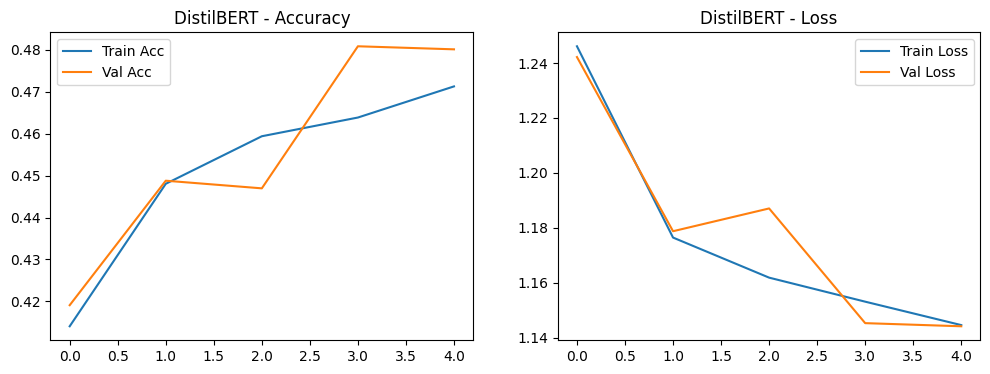

172/172 [==============================] - 13s 70ms/step

=== Classification Report: DistilBERT ===
              precision    recall  f1-score   support

     neutral       0.56      0.45      0.50      1728
       worry       0.46      0.51      0.48      1692
   happiness       0.49      0.59      0.54      1042
     sadness       0.40      0.37      0.38      1033

    accuracy                           0.48      5495
   macro avg       0.48      0.48      0.47      5495
weighted avg       0.48      0.48      0.48      5495



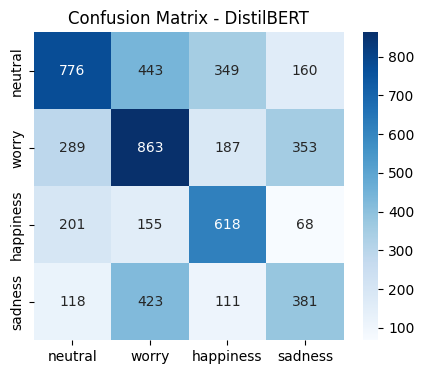

✅ DistilBERT berhasil disimpan lengkap di folder: ./saved_models/distilbert_emotion_final


In [ ]:
print("\n--- Membangun Model DistilBERT ---")
MODEL_NAME_1 = 'distilbert-base-uncased'
tokenizer_distil = AutoTokenizer.from_pretrained(MODEL_NAME_1)

train_ds_1 = get_transformer_data(tokenizer_distil, X_train_raw, y_train).shuffle(1000).batch(BATCH_SIZE)
test_ds_1 = get_transformer_data(tokenizer_distil, X_test_raw, y_test).batch(BATCH_SIZE)

# Load Model (from_pt=True untuk fix safetensors)
model_distilbert = TFAutoModelForSequenceClassification.from_pretrained(MODEL_NAME_1, num_labels=4, from_pt=True)

# Freeze Base Layer (Hanya train classifier di top layer agar tidak merusak pre-trained weights)
model_distilbert.layers[0].trainable = False

# Compile menggunakan tf_keras (Legacy)
optimizer = tf_keras.optimizers.Adam(learning_rate=1e-4)
loss = tf_keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_distilbert.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Callbacks (save_weights_only=True untuk fix NotImplementedError)
callbacks_distil = [
    tf_keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    tf_keras.callbacks.ModelCheckpoint('best_model_distilbert.h5', save_best_only=True, monitor='val_loss', save_weights_only=True)
]

history_distil = model_distilbert.fit(
    train_ds_1,
    epochs=5,
    validation_data=test_ds_1,
    callbacks=callbacks_distil,
    class_weight=class_weights
)

# Evaluasi Manual (Convert test data ke dict)
test_encodings_1 = tokenizer_distil(X_test_raw.tolist(), truncation=True, padding=True, max_length=128, return_tensors='tf')
evaluate_model(model_distilbert, dict(test_encodings_1), y_test, history_distil, "DistilBERT", is_transformer=True)

save_path_distil = "./saved_models/distilbert_emotion_final"
tokenizer_distil.save_pretrained(save_path_distil) # Simpan Tokenizer
model_distilbert.save_pretrained(save_path_distil) # Simpan Model & Config
print(f"✅ DistilBERT berhasil disimpan lengkap di folder: {save_path_distil}")

## MODEL 3: Pretrained 2 (RoBERTa)


--- Membangun Model RoBERTa ---


All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
1374/1374 [==============================] - 189s 129ms/step - loss: 1.3556 - accuracy: 0.3411 - val_loss: 1.3274 - val_accuracy: 0.3514
Epoch 2/5
1374/1374 [==============================] - 173s 126ms/step - loss: 1.2921 - accuracy: 0.4017 - val_loss: 1.2480 - val_accuracy: 0.4542
Epoch 3/5
1374/1374 [==============================] - 173s 126ms/step - loss: 1.2607 - accuracy: 0.4174 - val_loss: 1.2468 - val_accuracy: 0.4167
Epoch 4/5
1374/1374 [==============================] - 167s 122ms/step - loss: 1.2447 - accuracy: 0.4274 - val_loss: 1.2146 - val_accuracy: 0.4755
Epoch 5/5
1374/1374 [==============================] - 168s 122ms/step - loss: 1.2368 - accuracy: 0.4374 - val_loss: 1.2094 - val_accuracy: 0.4662


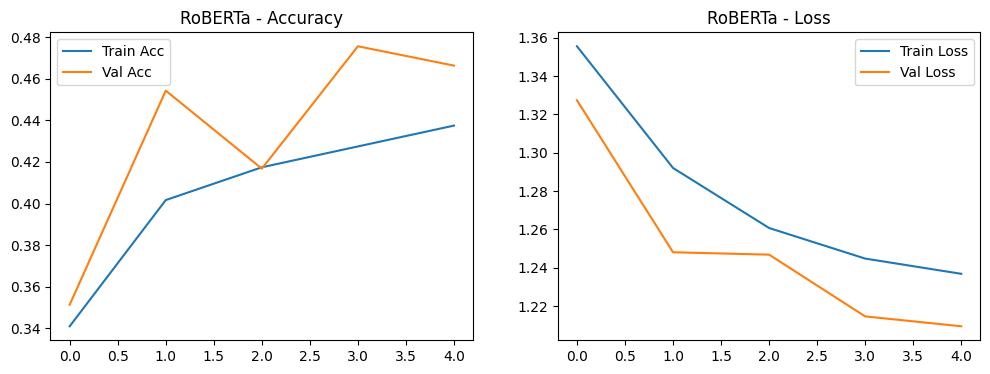

172/172 [==============================] - 35s 182ms/step

=== Classification Report: RoBERTa ===
              precision    recall  f1-score   support

     neutral       0.59      0.45      0.51      1728
       worry       0.48      0.30      0.37      1692
   happiness       0.48      0.67      0.56      1042
     sadness       0.35      0.56      0.43      1033

    accuracy                           0.47      5495
   macro avg       0.47      0.50      0.47      5495
weighted avg       0.49      0.47      0.46      5495



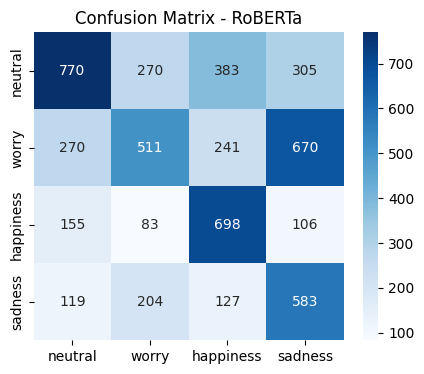

✅ RoBERTa berhasil disimpan lengkap di folder: ./saved_models/roberta_emotion_final


In [ ]:
print("\n--- Membangun Model RoBERTa ---")
MODEL_NAME_2 = 'roberta-base'
tokenizer_roberta = AutoTokenizer.from_pretrained(MODEL_NAME_2)

train_ds_2 = get_transformer_data(tokenizer_roberta, X_train_raw, y_train).shuffle(1000).batch(BATCH_SIZE)
test_ds_2 = get_transformer_data(tokenizer_roberta, X_test_raw, y_test).batch(BATCH_SIZE)

# Load Model
model_roberta = TFAutoModelForSequenceClassification.from_pretrained(MODEL_NAME_2, num_labels=4, from_pt=True)

# Freeze Base Layer
model_roberta.layers[0].trainable = False

# Compile
optimizer = tf_keras.optimizers.Adam(learning_rate=1e-4)
loss = tf_keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_roberta.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Callbacks
callbacks_roberta = [
    tf_keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    tf_keras.callbacks.ModelCheckpoint('best_model_roberta.h5', save_best_only=True, monitor='val_loss', save_weights_only=True)
]

history_roberta = model_roberta.fit(
    train_ds_2,
    epochs=5,
    validation_data=test_ds_2,
    callbacks=callbacks_roberta,
    class_weight=class_weights
)

# Evaluasi Manual
test_encodings_2 = tokenizer_roberta(X_test_raw.tolist(), truncation=True, padding=True, max_length=128, return_tensors='tf')
evaluate_model(model_roberta, dict(test_encodings_2), y_test, history_roberta, "RoBERTa", is_transformer=True)

save_path_roberta = "./saved_models/roberta_emotion_final"
tokenizer_roberta.save_pretrained(save_path_roberta) # Simpan Tokenizer
model_roberta.save_pretrained(save_path_roberta)     # Simpan Model & Config
print(f"✅ RoBERTa berhasil disimpan lengkap di folder: {save_path_roberta}")